In [1]:
import torch
import os
from model import load_model, detect
from inputs import sports_input
from baseline import BaselineAttack
from discrete_alteration import DiscreteAlterations
from paraphrasing import ParaphrasingAttack
from tokenization import TokenizationAttack
import matplotlib.pyplot as plt


/Users/alexandernemecek/Desktop/github/Topic-Based-LLM-Watermarks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./watermarked_outputs/sports_watermarked.txt', 'r') as file:
    content = file.read()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = {
    'demo_public': False, 
    # 'model_name_or_path': 'facebook/opt-125m', 
    'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    'use_gpu': True, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.7, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 1.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
    'is_topic': True,
    'topic_token_mapping': {
        "sports": list(range(20000)),
        "animals": list(range(20000, 40000)),
        "technology": list(range(40000, 60000)),
        # Add more topics and corresponding tokens as needed
    },
    'detected_topic': "",
}

In [3]:
# Original text
input_text = sports_input()
model, tokenizer = load_model(args)

input_prompt = input_text + content

with_watermark_detection_result = detect(input_prompt, content, 
                                        args, 
                                        device=device, 
                                        tokenizer=tokenizer)


print(f"Original Detection: \n{with_watermark_detection_result}")
for item in with_watermark_detection_result:
    if len(item) > 0:
        if item[0] == 'z-score':
            original_z_score = float(item[1])
            break

Original Detection: 
[['Tokens Counted (T)', '200'], ['# Tokens in Greenlist', '154'], ['Fraction of T in Greenlist', '77.0%'], ['z-score', '2.16'], ['p value', '0.0154'], ['z-score Threshold', '1.0'], ['Prediction', 'Watermarked'], ['Confidence', '98.462%'], []]


In [19]:
baseline = BaselineAttack()
n_modifications = list(range(0, 21, 10)) # 10 increments

z_score_results = {'insertion': [], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
robustness_scores = {'insertion': [], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
quality_results = {'insertion': [], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}

def evaluate_attack(attack_type, n_edits, inference=False):
    if attack_type == 'insertion':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='insert')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='insert')
    elif attack_type == 'deletion':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='delete')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='delete')
    elif attack_type == 'substitution':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='substitute')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='substitute')
    elif attack_type == 'combination':
        if inference:
            attacked_text = baseline.combination_modify_text(content, 
                                                        insertion_n_edits=n_edits//3, insertion_is_inferenced=True,
                                                        deletion_n_edits=n_edits//3, deletion_is_inferenced=True,
                                                        substitution_n_edits=n_edits//3, substitution_is_inferenced=True)
        else:
            attacked_text = baseline.combination_modify_text(content, 
                                                        insertion_n_edits=n_edits//3, 
                                                        deletion_n_edits=n_edits//3, 
                                                        substitution_n_edits=n_edits//3)
    return attacked_text

for n in n_modifications:
    print(n)
    for attack_type in ['insertion', 'deletion', 'substitution', 'combination']:
        print(attack_type)
        attacked_text = evaluate_attack(attack_type, n)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('detection finished')

        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[attack_type].append(z_score)
        print(z_score_results)

        if n > 0:  
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0

        robustness_scores[attack_type].append(robustness_score)

        # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
        # quality_results[attack_type].append(semantic_similarity)

        inference_attack_type = f'inference_{attack_type}'
        attacked_text = evaluate_attack(attack_type, n, inference=True)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[inference_attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[inference_attack_type].append(robustness_score)
        # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
        # quality_results[inference_attack_type].append(semantic_similarity)

0
insertion
detection finished
{'insertion': [2.43], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
deletion
detection finished
{'insertion': [2.43], 'deletion': [2.43], 'substitution': [], 'combination': [], 'inference_insertion': [2.43], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
substitution
detection finished
{'insertion': [2.43], 'deletion': [2.43], 'substitution': [2.43], 'combination': [], 'inference_insertion': [2.43], 'inference_deletion': [2.43], 'inference_substitution': [], 'inference_combination': []}
combination
detection finished
{'insertion': [2.43], 'deletion': [2.43], 'substitution': [2.43], 'combination': [2.16], 'inference_insertion': [2.43], 'inference_deletion': [2.43], 'inference_substitution': [2.43], 'inference_combination': []}
10
insertion
detection finished
{'insertion': [2.43, 1.96], 'deletion': [2

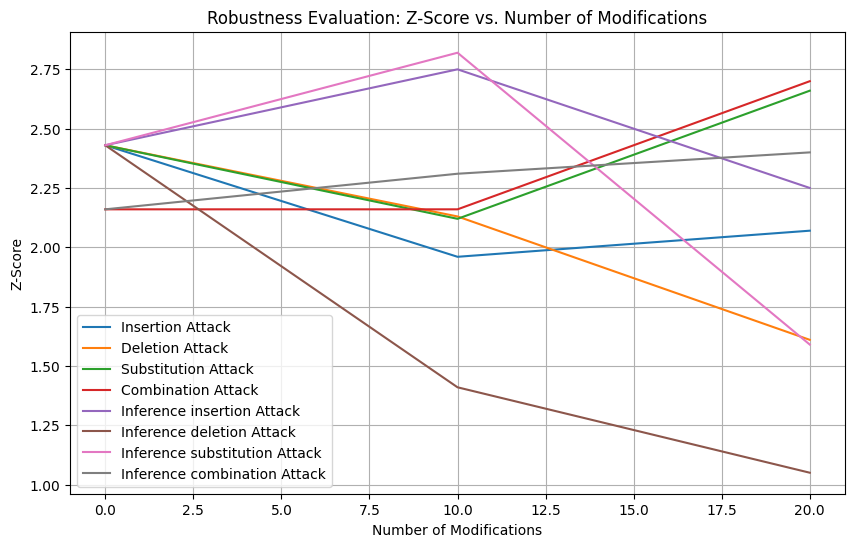

In [20]:
plt.figure(figsize=(10, 6))
for attack_type, z_scores in z_score_results.items():
    plt.plot(n_modifications, z_scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Baseline Attack Robustness Evaluation: Z-Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

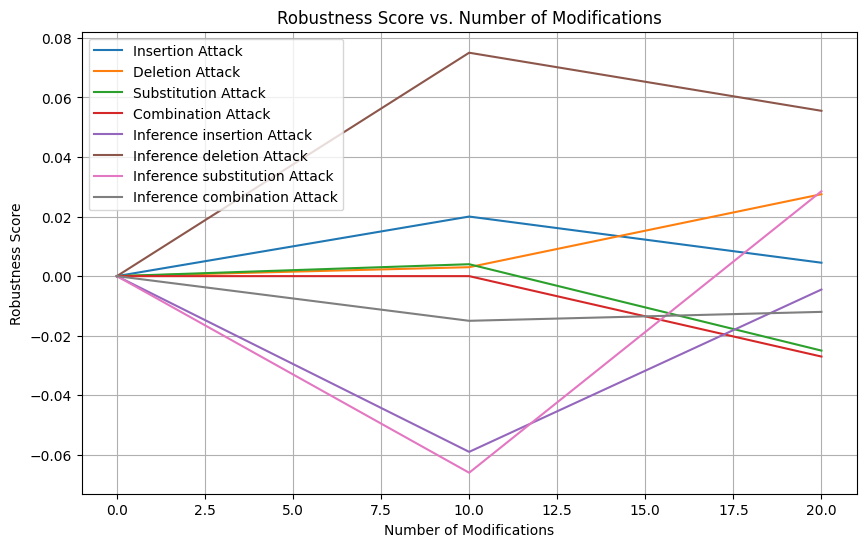

In [21]:
plt.figure(figsize=(10, 6))
for attack_type, scores in robustness_scores.items():
    plt.plot(n_modifications, scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Baseline Attack Robustness Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Robustness Score')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
n_modifications = list(range(0, 3, 1)) 

# Lists to store results
z_score_results = {'whitespace': [], 'add_char': [], 'combination': [], 'inference_whitespace': [], 'inference_add_char': [], 'inference_combination': []}
quality_results = {'whitespace': [], 'add_char': [], 'combination': [],'inference_whitespace': [], 'inference_add_char': [], 'inference_combination': []}
robustness_scores = {'whitespace': [], 'add_char': [], 'combination': [], 'inference_whitespace': [], 'inference_add_char': [], 'inference_combination': []}

alteration = DiscreteAlterations()

def evaluate_discrete_attack(attack_type, n_edits, inference=False):
    if attack_type == 'whitespace':
        attacked_text = alteration.add_whitespace(content, n_edits, inference=inference)
    elif attack_type == 'add_char':
        attacked_text = alteration.add_char(content, n_edits, inference=inference)
    elif attack_type == 'combination':
        attacked_text = alteration.combination_modify_text(content, 
                                                           whitespace_n_edits=n_edits//2, white_space_inference=inference,
                                                            add_char_n_edits=n_edits//2, add_char_inference=inference)
    return attacked_text



for n in n_modifications:
    print(n)
    for attack_type in ['whitespace', 'add_char', 'combination']:
        print(attack_type)

        attacked_text = evaluate_discrete_attack(attack_type, n)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('non-inference detection finished')

        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[attack_type].append(robustness_score)
        # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
        # quality_results[attack_type].append(semantic_similarity)

        inference_attack_type = f'inference_{attack_type}'
        attacked_text = evaluate_discrete_attack(attack_type, n, inference=True)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('inference detection finished')
        
        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[inference_attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[inference_attack_type].append(robustness_score)
        # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
        # quality_results[inference_attack_type].append(semantic_similarity)

0
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
1
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
2
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished


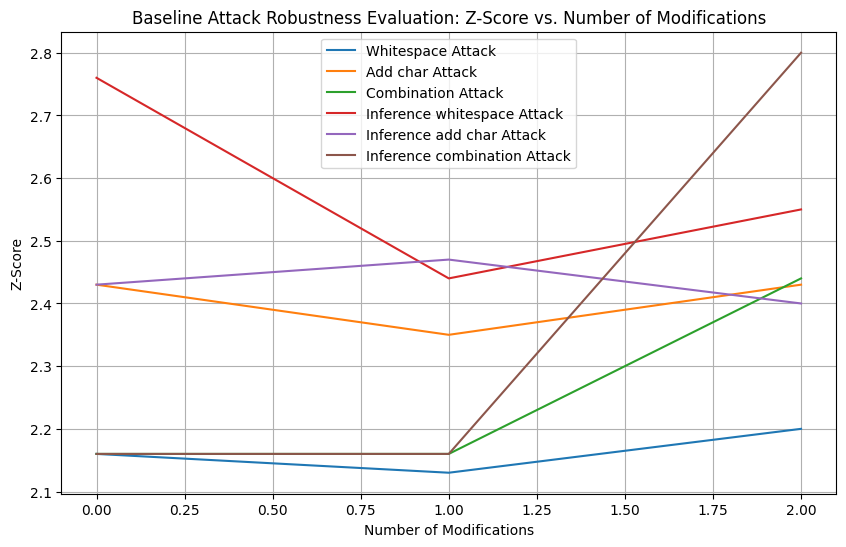

In [6]:
plt.figure(figsize=(10, 6))
for attack_type, z_scores in z_score_results.items():
    plt.plot(n_modifications, z_scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Discrete Alterations Robustness Evaluation: Z-Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

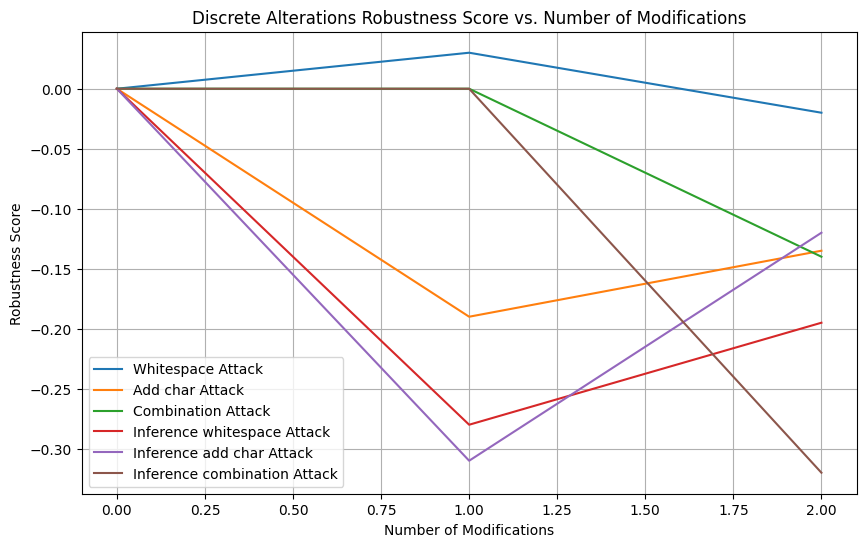

In [7]:
plt.figure(figsize=(10, 6))
for attack_type, scores in robustness_scores.items():
    plt.plot(n_modifications, scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Discrete Alterations Robustness Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Robustness Score')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
n_modifications = list(range(0, 11, 5))

z_score_results = {'tokenization': [], 'inference_tokenization': []}
quality_results = {'tokenization': [], 'inference_tokenization': []}
robustness_scores = {'tokenization': [], 'inference_tokenization': []}

tokenization = TokenizationAttack()

def evaluate_tokenization_attack(n_edits, inference=False):
    attacked_text = tokenization.tokenization_attack(content, n_edits, insert_char='_', max_insertions_per_word=3, inference=inference)
    return attacked_text


for n in n_modifications:
    attacked_text = evaluate_tokenization_attack(n)
    attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
    for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
    z_score_results['tokenization'].append(z_score)
    if n > 0:
        robustness_score = (original_z_score - z_score) / n
    else:
        robustness_score = 0
    robustness_scores['tokenization'].append(robustness_score)
    # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
    # quality_results['tokenization'].append(semantic_similarity)

    attacked_text = evaluate_tokenization_attack(n, inference=True)
    attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
    for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
    z_score_results['inference_tokenization'].append(z_score)
    if n > 0:
        robustness_score = (original_z_score - z_score) / n
    else:
        robustness_score = 0
    robustness_scores['inference_tokenization'].append(robustness_score)
    # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
    # quality_results['inference_tokenization'].append(semantic_similarity)

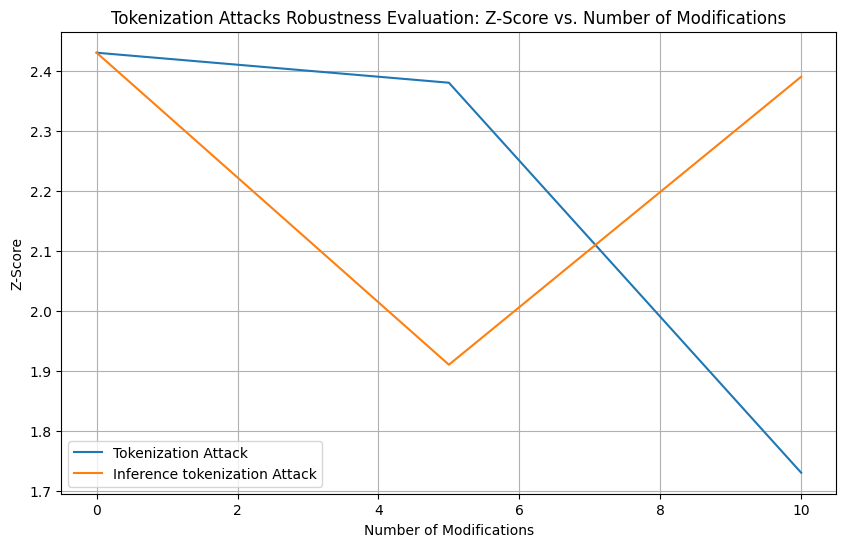

In [10]:
plt.figure(figsize=(10, 6))
for attack_type, z_scores in z_score_results.items():
    plt.plot(n_modifications, z_scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Tokenization Attacks Robustness Evaluation: Z-Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

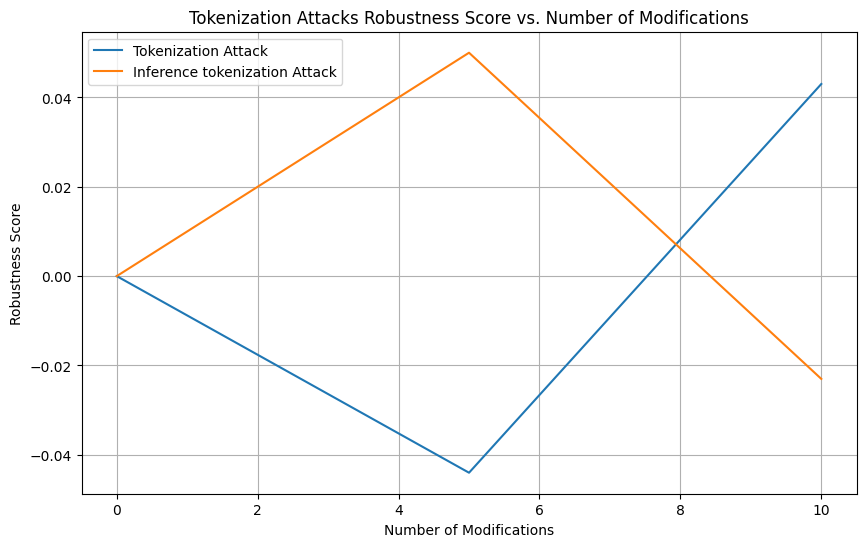

In [11]:
plt.figure(figsize=(10, 6))
for attack_type, scores in robustness_scores.items():
    plt.plot(n_modifications, scores, label=f'{attack_type.replace("_", " ").capitalize()} Attack')

plt.title('Tokenization Attacks Robustness Score vs. Number of Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Robustness Score')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
access_token = os.environ.get('HUGGINGFACEHUB_API_TOKEN')

paraphraser = ParaphrasingAttack(access_token=access_token)

attacked_text = paraphraser.rephrase(content)
attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
for item in attacked_detection_result:
        if len(item) > 0:
            if item[0] == 'z-score':
                z_score = float(item[1])
                break

attacked_text = paraphraser.rephrase(content, topic='sports', inference=True)
attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
for item in attacked_detection_result:
        if len(item) > 0:
            if item[0] == 'z-score':
                inference_z_score = float(item[1])
                break

print(original_z_score)
print(z_score)
print(inference_z_score)
    # semantic_similarity = evaluate_semantic_similarity(content, attacked_text)
    # quality_results['tokenization'].append(semantic_similarity)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/alexandernemecek/.cache/huggingface/token
Login successful
2.16
0.257
0.297
